# H-1B Prevailing Wage Project — Notebook 1  
## 01_Data_Ingestion_EDA_and_Splitting.ipynb

In this notebook we do **data ingestion → filtering/cleaning → basic EDA → target creation (log1p) → leakage prevention → Train/Val/Test split and save to `data/`**.

In [2]:
# =============================================================================
# 1. Imports & Configuration
# =============================================================================
import re
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.display import display

# Reproducibility / שחזור תוצאות
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Paths / נתיבים יחסיים (כמו בדרישה)
DATA_DIR = Path("data")
REPORTS_DIR = Path("reports")
FIGURES_DIR = REPORTS_DIR / "figures"

DATA_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams["figure.figsize"] = (10, 6)

def save_show(fig_name: str):
    """Save the current figure and show it (always use plt.show())."""
    out_path = FIGURES_DIR / fig_name
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")

def pick_first_existing(df, candidates):
    """Return first column name that exists in df, or None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

print("✅ Setup complete.\n")

✅ Setup complete.



## 2) Load dataset (CSV)
 
Load the main CSV from `data/`. Immediately after loading we show: `head`, `shape`, `dtypes`, and a quick missingness check.


In [4]:
# 2. Data Loading
# =============================================================================
# Expected file name (you already use this in the project)
csv_path = DATA_DIR / "h1b_data_cleaned.csv"
if not csv_path.exists():
    raise FileNotFoundError(
        f"Could not find {csv_path}. Put the cleaned dataset there (or update the path).")

#Added encoding='latin1' to fix UnicodeDecodeError
try:
    df = pd.read_csv(csv_path, low_memory=False, encoding='latin1')
except UnicodeDecodeError:
    # Fallback to cp1252 if latin1 fails
    df = pd.read_csv(csv_path, low_memory=False, encoding='cp1252')

print("--- Raw overview ---")
print("Shape:", df.shape)
display(df.head())
print("\nDtypes (top 25):")
display(df.dtypes.head(25))

print("\nTop missing columns:")
display(df.isna().sum().sort_values(ascending=False).head(10))

--- Raw overview ---
Shape: (1036449, 18)


,CASE_STATUS,ORIGINAL_CERT_DATE,VISA_CLASS,JOB_TITLE,SOC_TITLE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,EMPLOYER_NAME,EMPLOYER_STATE,NAICS_CODE,WORKSITE_CITY,WORKSITE_STATE,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,PREVAILING_WAGE,PW_UNIT_OF_PAY,H_1B_DEPENDENT,WILLFUL_VIOLATOR
0,Withdrawn,NaN,H-1B,Data Scientists,Data Scientists,Y,1.0,"Urban Outfitters, Inc.",PA,488190.0,Philadelphia,PA,"$175,000.00",Year,"$136,011.00",Year,No,No
1,Withdrawn,NaN,H-1B,IT Technical Associate - Developer II,Database Administrators,Y,1.0,Illinois Wesleyan University,IL,611310.0,Charleston,IL,"$54,500.00",Year,"$50,877.00",Year,No,No
2,Withdrawn,NaN,H-1B,Research Associate,Biochemists and Biophysicists,Y,1.0,TRUSTEES OF THE UNIVERSITY OF PENNSYLVANIA,PA,611310.0,Philadelphia,PA,"$69,618.00",Year,"$69,618.00",Year,No,No
3,Withdrawn,NaN,H-1B,Business Architecture Manager,Computer Systems Analysts,Y,1.0,Accenture LLP,IL,5416.0,Houston,TX,"$146,300.00",Year,"$140,421.00",Year,No,No
4,Withdrawn,NaN,H-1B,Senior Manager,Computer and Information Systems Managers,Y,1.0,Wayfair LLC,MA,44912.0,Boston,MA,"$199,067.00",Year,"$194,626.00",Year,No,No



Dtypes (top 25):


CASE_STATUS                object
ORIGINAL_CERT_DATE         object
VISA_CLASS                 object
JOB_TITLE                  object
SOC_TITLE                  object
FULL_TIME_POSITION         object
TOTAL_WORKER_POSITIONS    float64
EMPLOYER_NAME              object
EMPLOYER_STATE             object
NAICS_CODE                float64
WORKSITE_CITY              object
WORKSITE_STATE             object
WAGE_RATE_OF_PAY_FROM      object
WAGE_UNIT_OF_PAY           object
PREVAILING_WAGE            object
PW_UNIT_OF_PAY             object
H_1B_DEPENDENT             object
WILLFUL_VIOLATOR           object
dtype: object


Top missing columns:


ORIGINAL_CERT_DATE       1014447
WILLFUL_VIOLATOR          567704
H_1B_DEPENDENT            567703
EMPLOYER_STATE            557585
WORKSITE_CITY             557444
PW_UNIT_OF_PAY            557444
PREVAILING_WAGE           557444
WAGE_UNIT_OF_PAY          557444
WAGE_RATE_OF_PAY_FROM     557444
WORKSITE_STATE            557444
dtype: int64

## 3) Filtering & basic cleaning (Certified / Full-time / Annual)

Apply the project filters:  
- Certified only (if column exists)  
- Full-time only (if column exists)  
- Annual wage only (if column exists), or explain if dataset is already clean  
Also: convert wage to numeric when needed and drop rows with missing target.


In [5]:
# =============================================================================
# 3. Filtering / Cleaning (robust to column-name variants)
# =============================================================================
# Identify key columns (dataset variants)
col_case_status = pick_first_existing(df, ["CASE_STATUS", "case_status"])
col_full_time = pick_first_existing(df, ["FULL_TIME_POSITION", "full_time_position"])
col_wage_unit = pick_first_existing(df, ["WAGE_UNIT_OF_PAY", "wage_unit_of_pay"])

# Wage target column in your project sometimes appears as PREVAILING_WAGE or prev_wage
col_wage = pick_first_existing(df, ["prev_wage", "PREVAILING_WAGE", "PREVAILING_WAGE_YEAR"])
if col_wage is None:
    raise ValueError("Could not find a wage target column (prev_wage / PREVAILING_WAGE / PREVAILING_WAGE_YEAR).")

print(f"Target wage column: {col_wage}")

# ---- Filters (only if columns exist) ----
before = df.shape[0]

if col_case_status is not None:
    df = df[df[col_case_status].astype(str).str.upper().eq("CERTIFIED")].copy()

if col_full_time is not None:
    df = df[df[col_full_time].astype(str).str.upper().eq("Y")].copy()

if col_wage_unit is not None:
    # Keep Year / YEAR / Annual-like (depending on dataset)
    unit = df[col_wage_unit].astype(str).str.upper()
    df = df[unit.isin(["YEAR", "ANNUAL", "YR"])].copy()

after = df.shape[0]
print(f"Rows: {before:,} → {after:,} after filters (only applied when relevant columns exist).")

# ---- Convert wage to numeric if needed ----
def to_float_money(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x)
    s = s.replace("$", "").replace(",", "").strip()
    try:
        return float(s)
    except Exception:
        return np.nan

if df[col_wage].dtype == "O":
    df[col_wage] = df[col_wage].apply(to_float_money)

# Drop invalid target
df = df.dropna(subset=[col_wage])
df = df[df[col_wage] > 0].copy()

print("\n--- After cleaning ---")
print("Shape:", df.shape)
display(df.head())
print("\nTop missing columns (post-cleaning):")
display(df.isna().sum().sort_values(ascending=False).head(10))

Target wage column: PREVAILING_WAGE
Rows: 1,036,449 → 415,316 after filters (only applied when relevant columns exist).

--- After cleaning ---
Shape: (415316, 18)


,CASE_STATUS,ORIGINAL_CERT_DATE,VISA_CLASS,JOB_TITLE,SOC_TITLE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,EMPLOYER_NAME,EMPLOYER_STATE,NAICS_CODE,WORKSITE_CITY,WORKSITE_STATE,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,PREVAILING_WAGE,PW_UNIT_OF_PAY,H_1B_DEPENDENT,WILLFUL_VIOLATOR
46,Certified,NaN,H-1B,Manager JC50 - Computer Systems Engineers/Arch...,Computer Systems Engineers/Architects,Y,1.0,COGNIZANT TECHNOLOGY SOLUTIONS US CORP,TX,541512.0,Plano,TX,"$109,886.00",Year,109886.0,Year,Yes,No
47,Certified,NaN,H-1B,Scientist I,Biochemists and Biophysicists,Y,1.0,Sanford Burnham Prebys Medical Discovery Insti...,CA,54171.0,La Jolla,CA,"$88,000.00",Year,60590.0,Year,No,No
49,Certified,NaN,H-1B,Lead Software Engineer,Software Developers,Y,1.0,Sabre GLBL Inc.,TX,541511.0,Southlake,TX,"$149,781.00",Year,149781.0,Year,No,No
50,Certified,NaN,H-1B,"GROWTH AND DATA MARKETING, SENIOR MANAGER",Data Scientists,Y,1.0,APEX FOR YOUTH INC.,NY,81341.0,New York,NY,"$82,763.00",Year,82763.0,Year,No,No
51,Certified,NaN,H-1B,"Vice President, Project Management",Business Intelligence Analysts,Y,1.0,GOLDMAN SACHS & CO. LLC,NY,523150.0,Salt Lake City,UT,"$114,200.00",Year,102170.0,Year,No,No



Top missing columns (post-cleaning):


ORIGINAL_CERT_DATE       415316
WILLFUL_VIOLATOR           7818
H_1B_DEPENDENT             7817
EMPLOYER_STATE              125
WORKSITE_CITY                 0
PW_UNIT_OF_PAY                0
PREVAILING_WAGE               0
WAGE_UNIT_OF_PAY              0
WAGE_RATE_OF_PAY_FROM         0
WORKSITE_STATE                0
dtype: int64

## 4) Target creation: `y_reg = log1p(wage)`

Wage is typically **right-skewed** (heavy tail). We therefore predict `log1p(wage)` to stabilize the distribution.  
We plot histograms before/after and save figures to `reports/figures/`.


Preview:


,prev_wage,y_reg
46,109886.0,11.607208
47,60590.0,11.011902
49,149781.0,11.916936
50,82763.0,11.323748
51,102170.0,11.534403


Shape: (415316, 19)


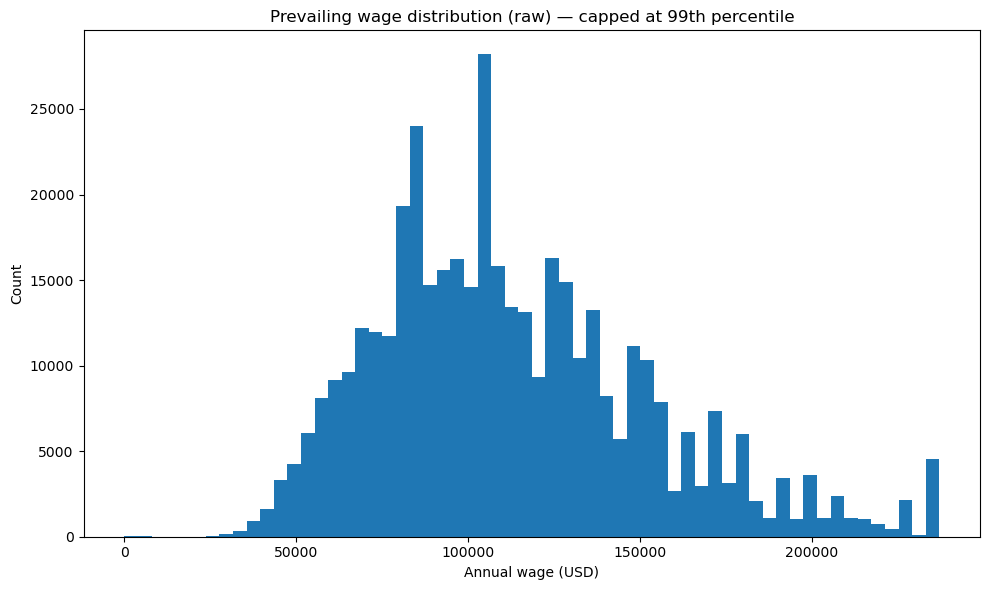

Saved: reports\figures\B3_hist_prev_wage.png


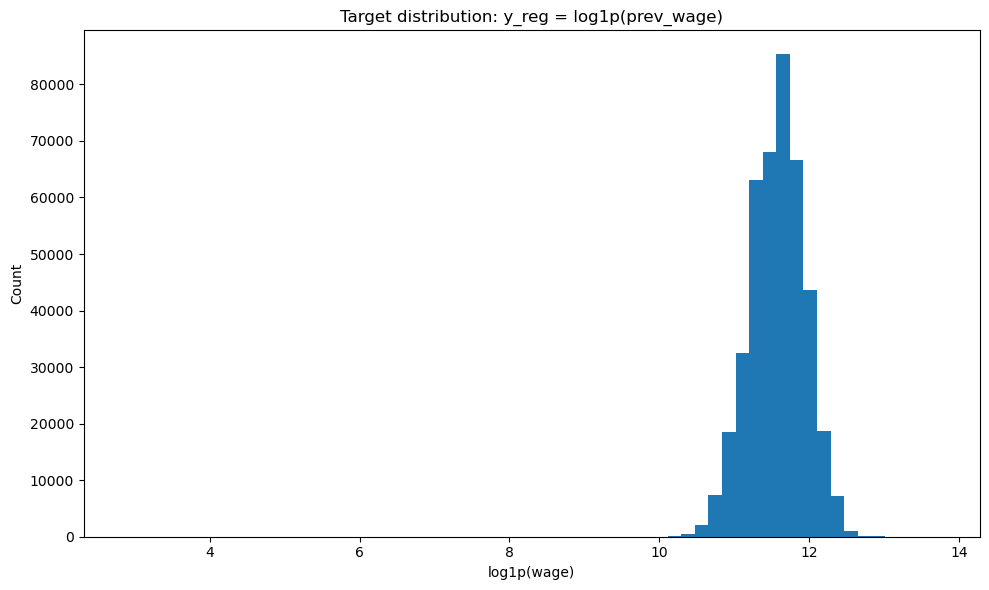

Saved: reports\figures\B3_hist_y_reg.png


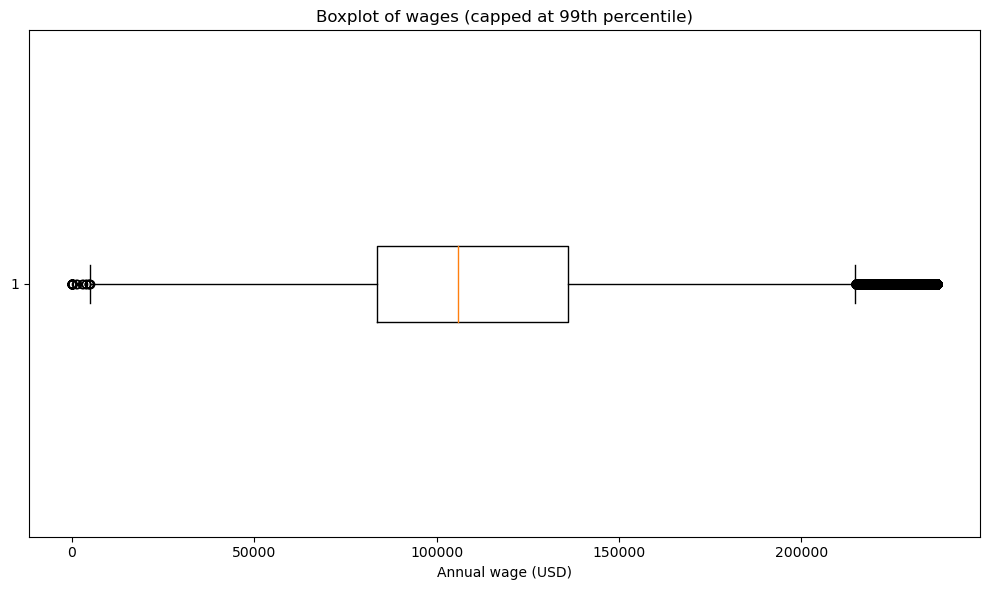

Saved: reports\figures\B3_boxplot_prev_wage_capped99.png


In [6]:
# =============================================================================
# 4. Target creation + distributions
# =============================================================================
# Standardize column names used downstream
df = df.rename(columns={col_wage: "prev_wage"}).copy()
df["y_reg"] = np.log1p(df["prev_wage"])

print("Preview:")
display(df[["prev_wage", "y_reg"]].head())
print("Shape:", df.shape)

# Histogram: raw wage
plt.figure()
plt.hist(df["prev_wage"].clip(upper=df["prev_wage"].quantile(0.99)), bins=60)
plt.title("Prevailing wage distribution (raw) — capped at 99th percentile")
plt.xlabel("Annual wage (USD)")
plt.ylabel("Count")
save_show("B3_hist_prev_wage.png")

# Histogram: log1p
plt.figure()
plt.hist(df["y_reg"], bins=60)
plt.title("Target distribution: y_reg = log1p(prev_wage)")
plt.xlabel("log1p(wage)")
plt.ylabel("Count")
save_show("B3_hist_y_reg.png")

# Boxplot capped at 99th percentile
q99 = df["prev_wage"].quantile(0.99)
plt.figure()
plt.boxplot(df.loc[df["prev_wage"] <= q99, "prev_wage"], vert=False)
plt.title("Boxplot of wages (capped at 99th percentile)")
plt.xlabel("Annual wage (USD)")
save_show("B3_boxplot_prev_wage_capped99.png")

## 5) Data leakage check & removal

Columns like wage ranges can **leak the target**.  
We:  
1) detect suspicious columns  
2) show a scatter plot (if available)  
3) drop them explicitly


In [7]:
# =============================================================================
# 5. Leakage check
# =============================================================================
leakage_candidates = [
    "WAGE_RATE_OF_PAY_FROM", "WAGE_RATE_OF_PAY_TO",
    "wage_from", "wage_to",
    "WAGE_FROM", "WAGE_TO"
]
existing_leak = [c for c in leakage_candidates if c in df.columns]

print("Leakage columns found:", existing_leak)

# If wage_from exists, show scatter vs prev_wage (example leakage)
scatter_x = pick_first_existing(df, ["WAGE_RATE_OF_PAY_FROM", "wage_from", "WAGE_FROM"])
if scatter_x is not None:
    x = pd.to_numeric(df[scatter_x], errors="coerce")
    y = df["prev_wage"]
    m = x.notna()
    if m.sum() > 0:
        plt.figure()
        plt.scatter(x[m].clip(upper=x[m].quantile(0.99)),
                    y[m].clip(upper=y[m].quantile(0.99)),
                    s=5, alpha=0.3)
        plt.title(f"Leakage check: {scatter_x} vs prev_wage (capped 99%)")
        plt.xlabel(scatter_x)
        plt.ylabel("prev_wage")
        save_show("B4_scatter_wage_from_vs_prev_wage.png")

# Drop leakage cols
df = df.drop(columns=existing_leak, errors="ignore")
print("After dropping leakage cols, shape:", df.shape)

Leakage columns found: ['WAGE_RATE_OF_PAY_FROM']
After dropping leakage cols, shape: (415316, 18)


## 6) EDA (basic business insights)
 
We generate first insights:  
- Median wage by State (WORKSITE / EMPLOYER)  
- Median wage by VISA_CLASS (if available)  
- Median wage by SOC_TITLE (if available)  
- Numeric correlation heatmap  
- Scatter NAICS_CODE vs wage (if available)


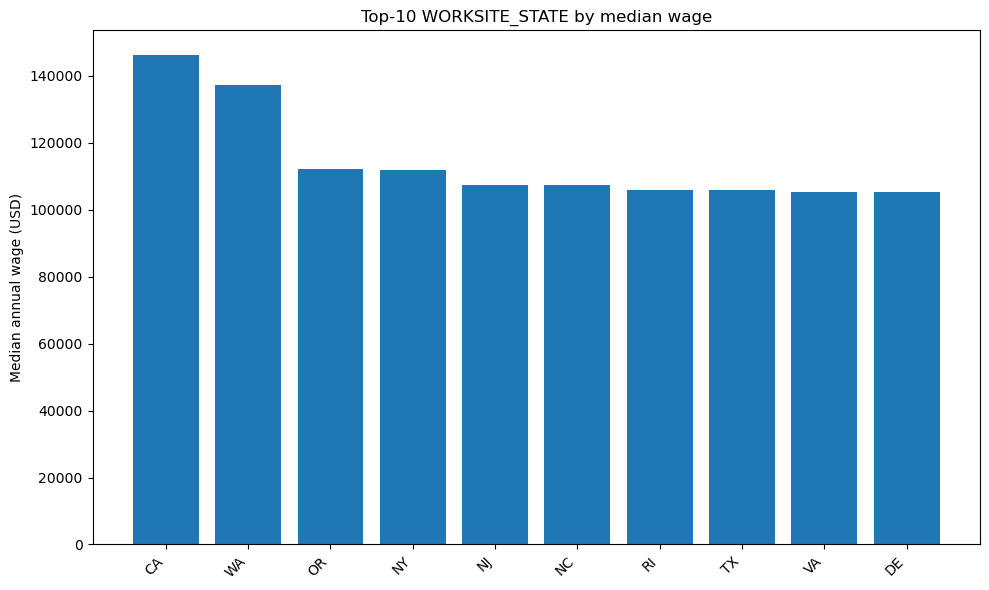

Saved: reports\figures\B5_median_WORKSITE_STATE_top10.png


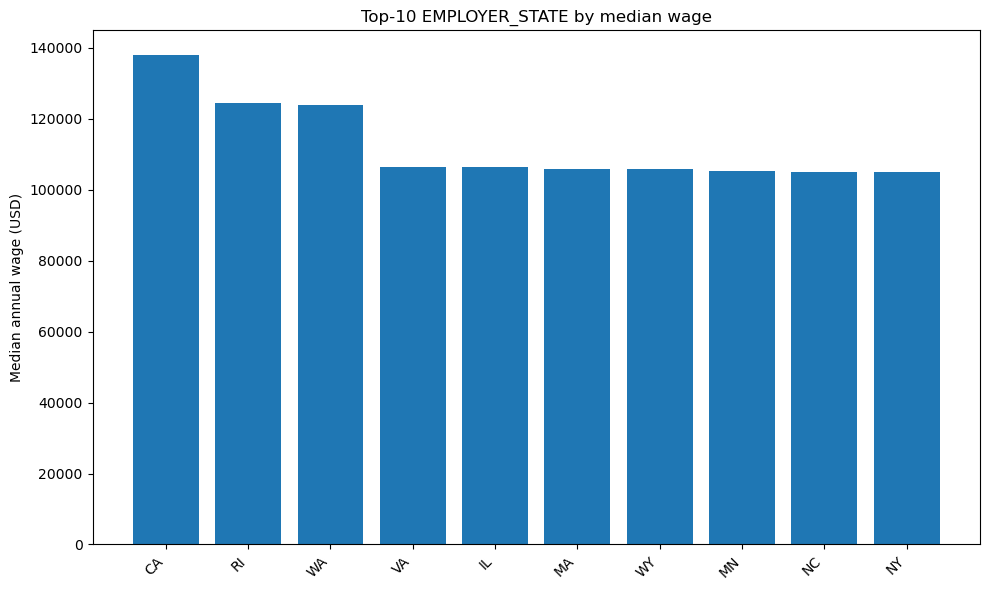

Saved: reports\figures\B5_median_EMPLOYER_STATE_top10.png


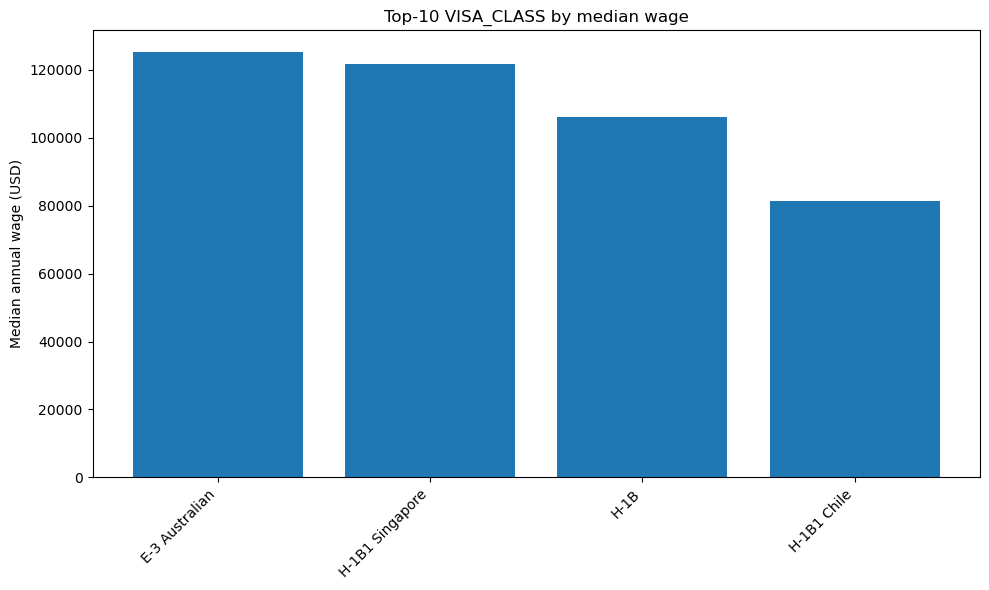

Saved: reports\figures\B5_median_VISA_CLASS_top10.png


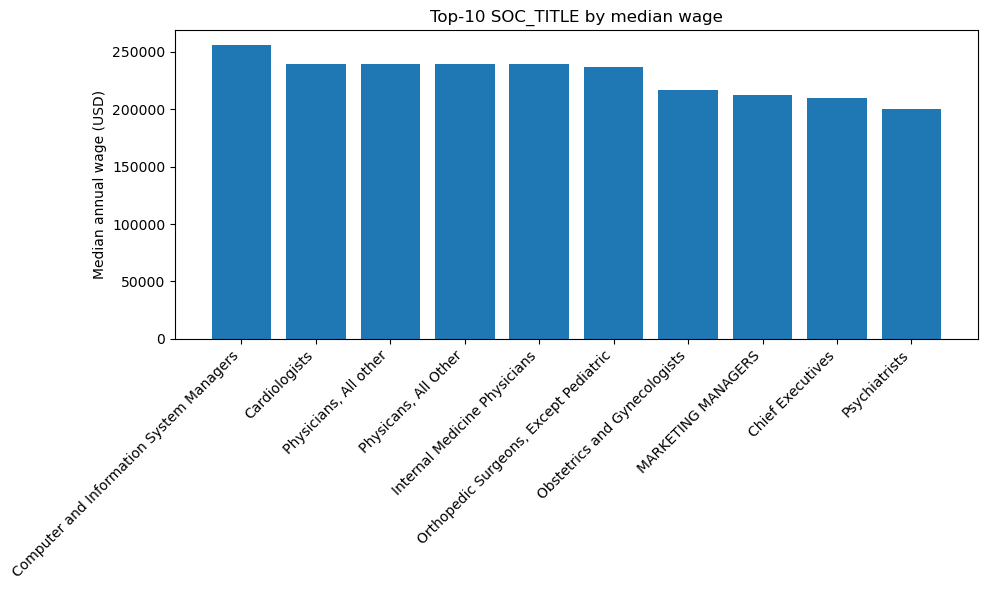

Saved: reports\figures\B5_median_SOC_TITLE_top10.png


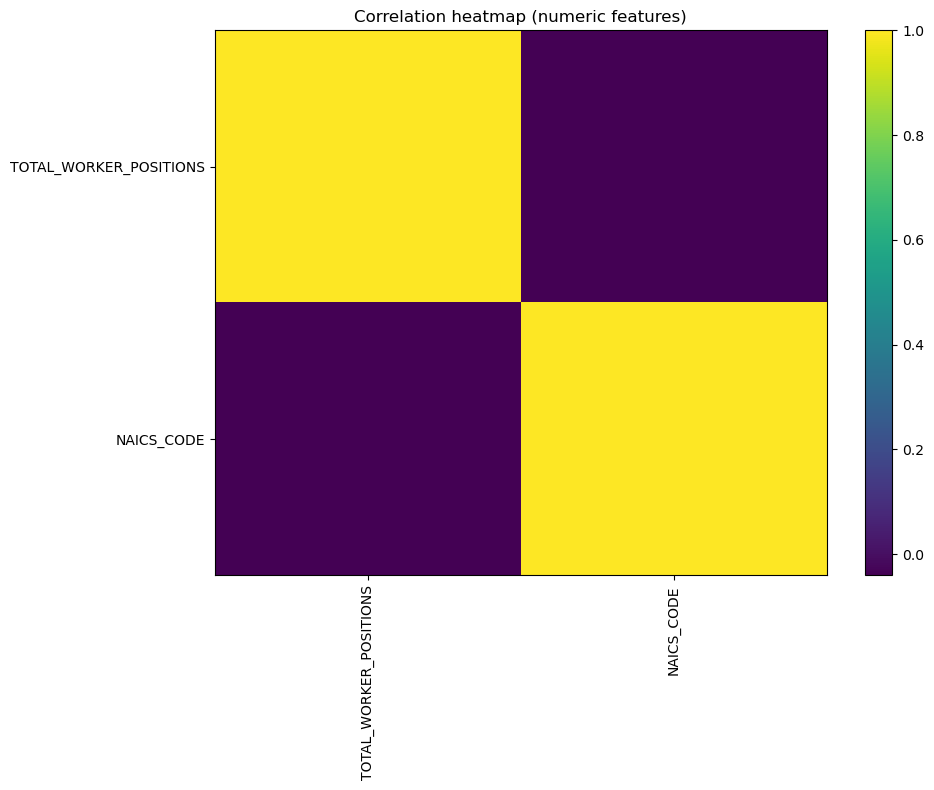

Saved: reports\figures\B4_corr_heatmap_numeric.png


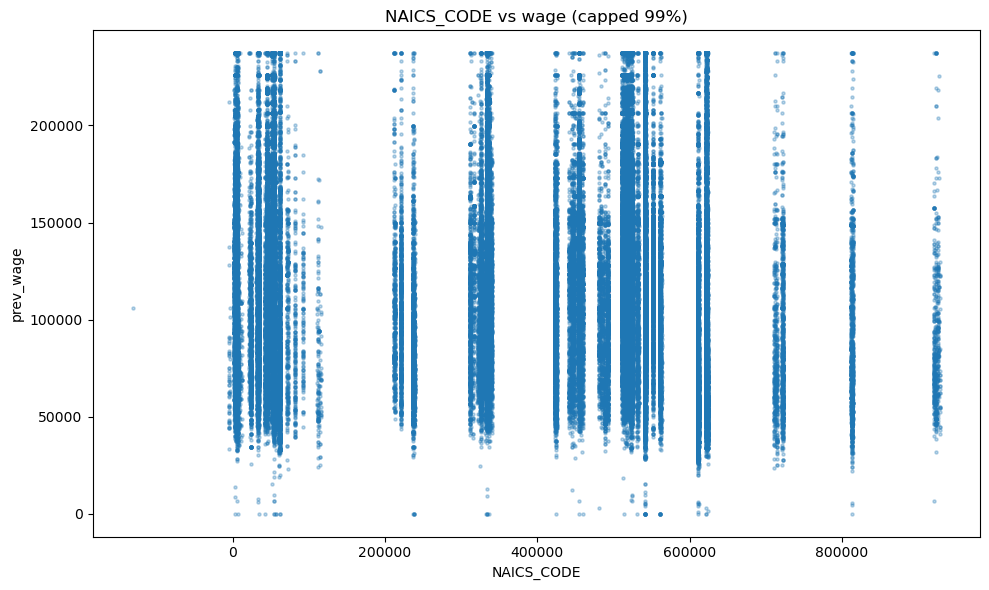

Saved: reports\figures\B4_scatter_NAICS_CODE_vs_prev_wage.png


In [8]:
# =============================================================================
# 6. EDA figures (saved + shown)
# =============================================================================
def plot_top10_median(df, col, fig_name, title):
    if col not in df.columns:
        print(f"Skip: column {col} not found")
        return
    tmp = (df.groupby(col)["prev_wage"]
           .median()
           .sort_values(ascending=False)
           .head(10))
    plt.figure()
    plt.bar(tmp.index.astype(str), tmp.values)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.ylabel("Median annual wage (USD)")
    save_show(fig_name)

# States
plot_top10_median(df, "WORKSITE_STATE", "B5_median_WORKSITE_STATE_top10.png", "Top-10 WORKSITE_STATE by median wage")
plot_top10_median(df, "EMPLOYER_STATE", "B5_median_EMPLOYER_STATE_top10.png", "Top-10 EMPLOYER_STATE by median wage")

# Visa class + SOC title (optional)
plot_top10_median(df, "VISA_CLASS", "B5_median_VISA_CLASS_top10.png", "Top-10 VISA_CLASS by median wage")
plot_top10_median(df, "SOC_TITLE", "B5_median_SOC_TITLE_top10.png", "Top-10 SOC_TITLE by median wage")

# Correlation heatmap (numeric only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove target + wage itself to avoid trivial correlations dominating
num_cols_for_corr = [c for c in num_cols if c not in ["prev_wage", "y_reg"]]

if len(num_cols_for_corr) >= 2:
    corr = df[num_cols_for_corr].corr()
    plt.figure(figsize=(10, 8))
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation heatmap (numeric features)")
    save_show("B4_corr_heatmap_numeric.png")
else:
    print("Skip correlation heatmap: not enough numeric columns.")

# NAICS scatter (optional)
if "NAICS_CODE" in df.columns:
    x = pd.to_numeric(df["NAICS_CODE"], errors="coerce")
    y = df["prev_wage"]
    m = x.notna()
    if m.sum() > 0:
        plt.figure()
        plt.scatter(x[m], y[m].clip(upper=y[m].quantile(0.99)), s=5, alpha=0.3)
        plt.title("NAICS_CODE vs wage (capped 99%)")
        plt.xlabel("NAICS_CODE")
        plt.ylabel("prev_wage")
        save_show("B4_scatter_NAICS_CODE_vs_prev_wage.png")

## 7) Train / Validation / Test split (Stratified by wage bins)

To keep tail representation, we create **bins of y_reg** and do a stratified split:  
- Train 80%  
- Validation 10%  
- Test 10%  
We save to `data/train.csv`, `data/val.csv`, `data/test.csv`.


In [9]:
# =============================================================================
# 7. Stratified split by wage bins
# =============================================================================
# Create bins (10 quantiles by default)
df = df.copy()
df["wage_bin"] = pd.qcut(df["y_reg"], q=10, labels=False, duplicates="drop")

train_df, tmp_df = train_test_split(
    df, test_size=0.20, random_state=SEED, stratify=df["wage_bin"]
)

val_df, test_df = train_test_split(
    tmp_df, test_size=0.50, random_state=SEED, stratify=tmp_df["wage_bin"]
)

# Drop helper column
for _d in (train_df, val_df, test_df):
    _d.drop(columns=["wage_bin"], inplace=True, errors="ignore")

print("Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)
display(train_df.head(3))

# Save splits
train_df.to_csv(DATA_DIR / "train.csv", index=False)
val_df.to_csv(DATA_DIR / "val.csv", index=False)
test_df.to_csv(DATA_DIR / "test.csv", index=False)

# Save metadata
meta = {
    "seed": SEED,
    "split": {"train": float(len(train_df)), "val": float(len(val_df)), "test": float(len(test_df))},
    "target": "y_reg = log1p(prev_wage)",
    "notes": "Filtered certified/full-time/annual when columns exist. Dropped leakage columns if present."
}
with open(REPORTS_DIR / "split_metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("✅ Saved splits to data/ and metadata to reports/split_metadata.json")

Train: (332252, 18)  Val: (41532, 18)  Test: (41532, 18)


,CASE_STATUS,ORIGINAL_CERT_DATE,VISA_CLASS,JOB_TITLE,SOC_TITLE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,EMPLOYER_NAME,EMPLOYER_STATE,NAICS_CODE,WORKSITE_CITY,WORKSITE_STATE,WAGE_UNIT_OF_PAY,prev_wage,PW_UNIT_OF_PAY,H_1B_DEPENDENT,WILLFUL_VIOLATOR,y_reg
357914,Certified,NaN,H-1B,Software Engineering,Software Developers,Y,1.0,Microsoft Corporation,WA,513210.0,Redmond,WA,Year,163862.0,Year,No,No,12.006786
357764,Certified,NaN,H-1B,Network Engineer,Network and Computer Systems Administrators,Y,1.0,Safeway Inc.,CA,445110.0,Anchorage,AK,Year,78624.0,Year,No,No,11.272445
268015,Certified,NaN,H-1B,Software Engineer,Software Developers,Y,20.0,"ServiceNow, Inc.",CA,541511.0,Santa Clara,CA,Year,132785.0,Year,No,No,11.796494


✅ Saved splits to data/ and metadata to reports/split_metadata.json


## ✅ End of Notebook 1

At this point we have:  
- Clean data + target (`prev_wage`, `y_reg`)  
- Figures saved to `reports/figures/`  
- Saved Train/Val/Test splits in `data/`
